This Project was done by 
* Mohamed Yassine Ezzaouia
* Bechir Ben Tekfa
* Yassine Yahyaoui


# Importing Libraries

In [1]:
import numpy as np 
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

import matplotlib.colors as mcolors
from matplotlib import patches
import matplotlib.patches as mpatches  

from sklearn.pipeline import Pipeline

import tensorflow as tf
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers, regularizers
import keras_tuner as kt 

# Getting Data

In [2]:
data= pd.read_csv("/kaggle/input/english-premier-league-players-dataset/epldata_final.csv")
data.head()

,name,club,age,position,position_cat,market_value,page_views,fpl_value,fpl_sel,fpl_points,region,nationality,new_foreign,age_cat,club_id,big_club,new_signing
0,Alexis Sanchez,Arsenal,28,LW,1,65.0,4329,12.0,17.10%,264,3.0,Chile,0,4,1,1,0
1,Mesut Ozil,Arsenal,28,AM,1,50.0,4395,9.5,5.60%,167,2.0,Germany,0,4,1,1,0
2,Petr Cech,Arsenal,35,GK,4,7.0,1529,5.5,5.90%,134,2.0,Czech Republic,0,6,1,1,0
3,Theo Walcott,Arsenal,28,RW,1,20.0,2393,7.5,1.50%,122,1.0,England,0,4,1,1,0
4,Laurent Koscielny,Arsenal,31,CB,3,22.0,912,6.0,0.70%,121,2.0,France,0,4,1,1,0


In [3]:
data.columns

Index(['name', 'club', 'age', 'position', 'position_cat', 'market_value',
       'page_views', 'fpl_value', 'fpl_sel', 'fpl_points', 'region',
       'nationality', 'new_foreign', 'age_cat', 'club_id', 'big_club',
       'new_signing'],
      dtype='object')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 461 entries, 0 to 460
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   name          461 non-null    object 
 1   club          461 non-null    object 
 2   age           461 non-null    int64  
 3   position      461 non-null    object 
 4   position_cat  461 non-null    int64  
 5   market_value  461 non-null    float64
 6   page_views    461 non-null    int64  
 7   fpl_value     461 non-null    float64
 8   fpl_sel       461 non-null    object 
 9   fpl_points    461 non-null    int64  
 10  region        460 non-null    float64
 11  nationality   461 non-null    object 
 12  new_foreign   461 non-null    int64  
 13  age_cat       461 non-null    int64  
 14  club_id       461 non-null    int64  
 15  big_club      461 non-null    int64  
 16  new_signing   461 non-null    int64  
dtypes: float64(3), int64(9), object(5)
memory usage: 61.4+ KB


In [5]:
data.isnull().sum()

name            0
club            0
age             0
position        0
position_cat    0
market_value    0
page_views      0
fpl_value       0
fpl_sel         0
fpl_points      0
region          1
nationality     0
new_foreign     0
age_cat         0
club_id         0
big_club        0
new_signing     0
dtype: int64

# Cleaning Data

In [6]:
data[data.region.isnull()]


,name,club,age,position,position_cat,market_value,page_views,fpl_value,fpl_sel,fpl_points,region,nationality,new_foreign,age_cat,club_id,big_club,new_signing
188,Steve Mounie,Huddersfield,22,CF,1,5.5,56,6.0,0.60%,0,NaN,Benin,0,2,8,0,0


In [7]:
data[data.region.isnull()]


,name,club,age,position,position_cat,market_value,page_views,fpl_value,fpl_sel,fpl_points,region,nationality,new_foreign,age_cat,club_id,big_club,new_signing
188,Steve Mounie,Huddersfield,22,CF,1,5.5,56,6.0,0.60%,0,NaN,Benin,0,2,8,0,0


In [8]:
data = data[data['nationality'] != 'Israel']

In [9]:
data.dropna(inplace=True)
data[data.region.isnull()]

,name,club,age,position,position_cat,market_value,page_views,fpl_value,fpl_sel,fpl_points,region,nationality,new_foreign,age_cat,club_id,big_club,new_signing


In [10]:
 data[['region', 'nationality']] .value_counts()  .reset_index(name='count') .groupby('region') .head(3) .set_index('region') .sort_index() 

,nationality,count
region,,
1.0,England,154
1.0,Wales,2
2.0,France,25
2.0,Spain,28
2.0,Netherlands,20
3.0,Argentina,16
3.0,Jamaica,2
3.0,Brazil,12
4.0,Nigeria,6


In [11]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
unmatched = data[~data['nationality'].isin(world['name'])]['nationality'].unique()
if len(unmatched) > 0:
    print("The following nationalities were not found in the GeoPandas dataset:")
    for nation in unmatched:
        print(f"- {nation}")
else:
    print("All nationalities were successfully matched.")

The following nationalities were not found in the GeoPandas dataset:
- Czech Republic
- England
- Wales
- Bosnia
- Scotland
- Congo DR
- Cote d'Ivoire
- Northern Ireland
- Curacao
- Bermuda
- United States
- The Gambia


In [12]:
def standardize_country(name):
    special_cases = {
        "czech republic	": 'Czechia',
        "england": "United Kingdom",
        "scotland": "United Kingdom",
        "wales": "United Kingdom",
        "northern ireland": "United Kingdom",
        "united states": "United States of America",
        "cote d'ivoire": "Côte d'Ivoire",
        "congo dr": "Congo",
        "curacao": "Netherlands",
        "bosnia": "Bosnia and Herz.",
        "the gambia": "Gambia",
        "bermuda": "United Kingdom",
    }
    return special_cases.get(name.lower(), name)


df=pd.DataFrame(data)
df['standard_nationality'] = df['nationality'].apply(standardize_country)
unmatched = df[~df['standard_nationality'].isin(world['name'])]['nationality'].unique()
if len(unmatched) > 0:
    print("The following nationalities were not found in the GeoPandas dataset:")
    for nation in unmatched:
        print(f"- {nation}")
else:
    print("All nationalities were successfully matched.")


The following nationalities were not found in the GeoPandas dataset:
- Czech Republic


In [13]:
country_counts = df.groupby(['standard_nationality', 'region']).size().reset_index(name='count')
country_counts

,standard_nationality,region,count
0,Algeria,4.0,3
1,Argentina,2.0,1
2,Argentina,3.0,16
3,Armenia,4.0,1
4,Australia,4.0,4
5,Austria,2.0,4
6,Belgium,2.0,18
7,Bosnia and Herz.,2.0,2
8,Brazil,3.0,12
9,Cameroon,2.0,1


In [14]:
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253.0,Africa,W. Sahara,ESH,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,328239523.0,North America,United States of America,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


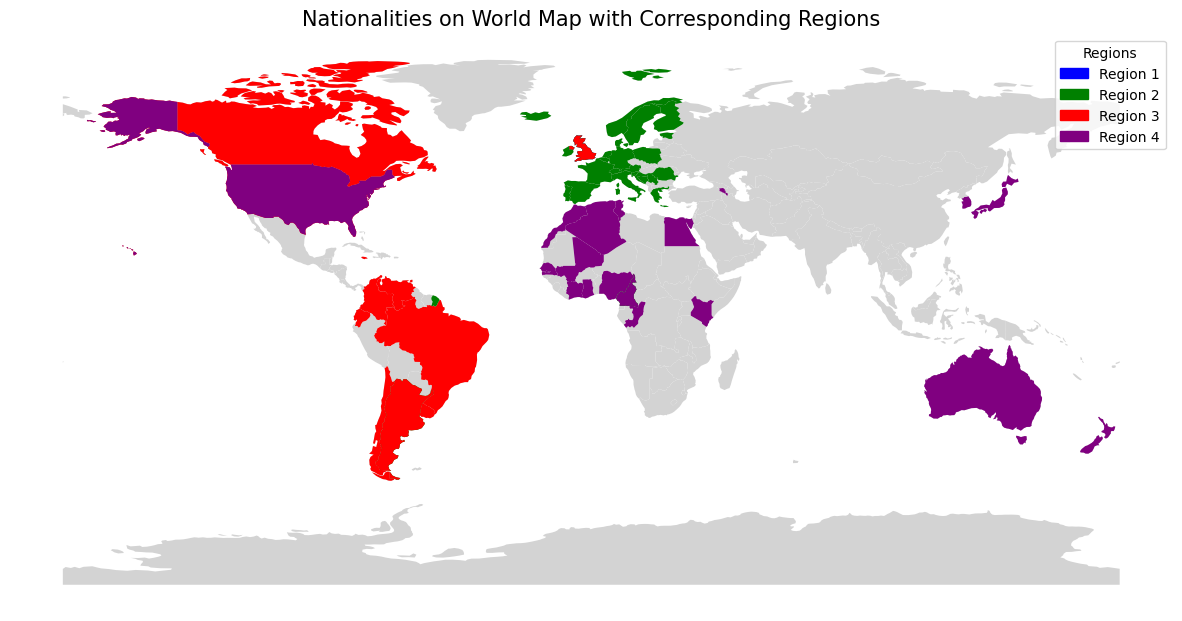

In [15]:
merged = world.merge(country_counts, left_on='name', right_on='standard_nationality', how='left')
merged=merged.dropna()

region_colors = {1: 'blue', 2: 'green', 3: 'red', 4: 'purple'} 

fig, ax = plt.subplots(1, 1, figsize=(15, 10))

world.plot(ax=ax, color='lightgrey')

merged.plot(ax=ax, column='region', cmap=mcolors.ListedColormap([region_colors.get(i) for i in [1, 2, 3, 4]]), legend=False)


handles = [patches.Patch(color=region_colors[1], label='Region 1'),
           patches.Patch(color=region_colors[2], label='Region 2'),
           patches.Patch(color=region_colors[3], label='Region 3'),
           patches.Patch(color=region_colors[4], label='Region 4')]

ax.legend(handles=handles, title='Regions')

ax.set_title('Nationalities on World Map with Corresponding Regions', fontsize=15)
plt.axis('off')  
plt.show()


In [16]:
merged[merged.standard_nationality=='United Kingdom']

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,standard_nationality,region,count
146,66834405.0,Europe,United Kingdom,GBR,2829108,"MULTIPOLYGON (((-6.19788 53.86757, -6.95373 54...",United Kingdom,1.0,156.0
147,66834405.0,Europe,United Kingdom,GBR,2829108,"MULTIPOLYGON (((-6.19788 53.86757, -6.95373 54...",United Kingdom,2.0,32.0
148,66834405.0,Europe,United Kingdom,GBR,2829108,"MULTIPOLYGON (((-6.19788 53.86757, -6.95373 54...",United Kingdom,3.0,1.0


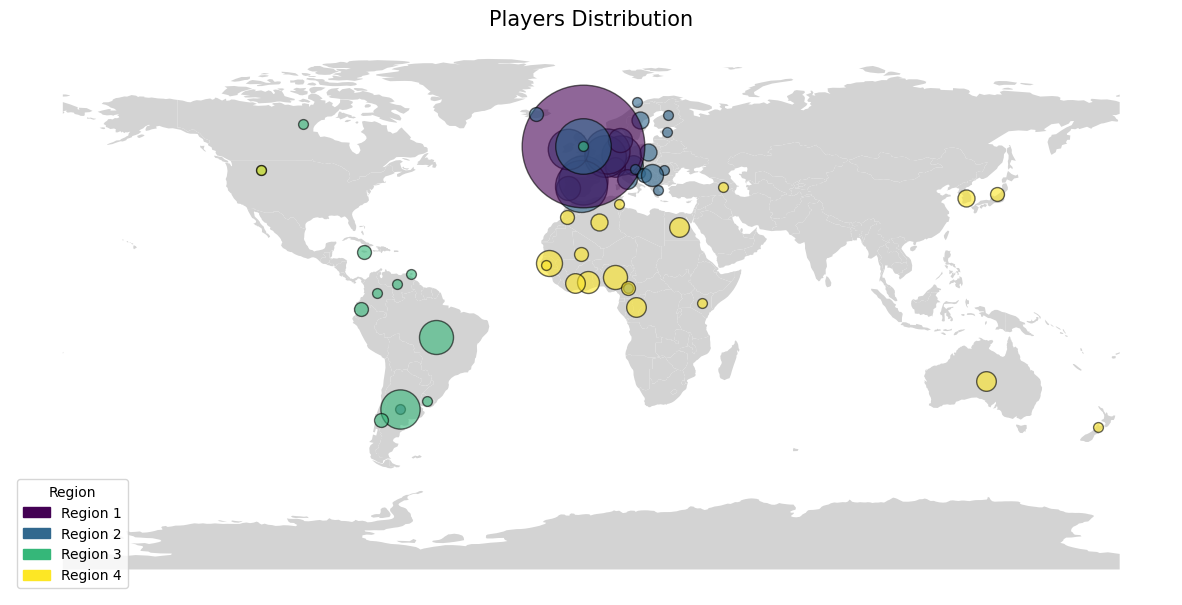

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.plot(ax=ax, color='lightgrey')

unique_regions = merged['region'].dropna().unique()
warnings.filterwarnings("ignore")

cmap = plt.cm.get_cmap('viridis', len(unique_regions))
region_colors = {region: cmap(i) for i, region in enumerate(sorted(unique_regions))}

for _, country in merged.iterrows():
        # Get the color based on region
        color = region_colors.get(country['region'], 'black')  # Default to black if region not found
        # Get the centroid
        centroid = country['geometry'].centroid
        ax.scatter(centroid.x, centroid.y, color=color, s=country['count'] * 50, alpha=0.6, edgecolor='k')

handles = []
labels = []

for region, color in region_colors.items():
    handles.append(mpatches.Patch(color=color))
    labels.append(f"Region {int(region)}")
ax.legend(handles, labels, title='Region', loc='lower left')

ax.set_title('Players Distribution', fontsize=15)
plt.axis('off')  
plt.show()

In [18]:
data.groupby(['nationality', 'region']).size().reset_index(name='count').sort_values('count', ascending=False).reset_index(drop=True)

,nationality,region,count
0,England,1.0,154
1,Spain,2.0,28
2,France,2.0,25
3,Netherlands,2.0,20
4,Belgium,2.0,18
...,...,...,...
59,Tunisia,4.0,1
60,United States,4.0,1
61,United States,3.0,1
62,Venezuela,3.0,1


In [19]:
data['fpl_sel'].describe()

count       458
unique      113
top       0.10%
freq         64
Name: fpl_sel, dtype: object

In [20]:
data['fpl_sel']=data['fpl_sel'].str.rstrip('%').astype(float)/100

data['fpl_sel'].describe()


count    458.000000
mean       0.032627
std        0.056897
min        0.000000
25%        0.002000
50%        0.010000
75%        0.033000
max        0.450000
Name: fpl_sel, dtype: float64

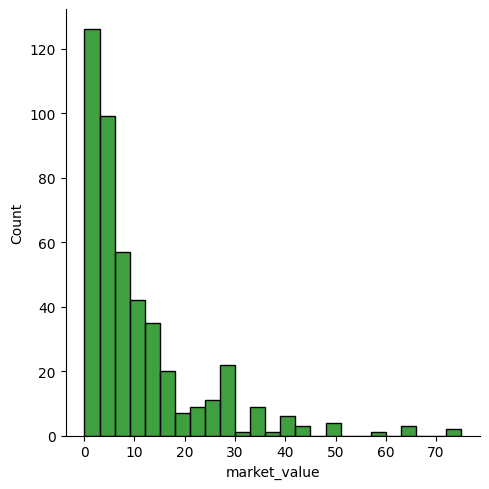

In [21]:
sns.displot(data.market_value,color='green')

<Axes: >

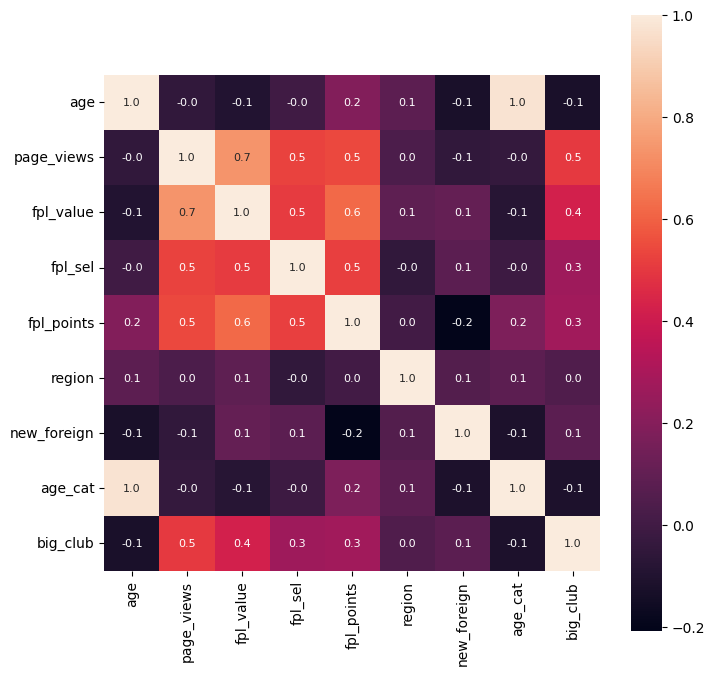

In [22]:
selected_features = ['age', 'page_views', 'fpl_value', 'fpl_sel', 'fpl_points', 
                    'region', 'new_foreign', 'age_cat', 'big_club']

corr_data = data[selected_features]

correlation = corr_data.corr()
plt.figure(figsize = (8,8))
sns.heatmap(correlation, cbar=True, square=True, fmt='.1f',annot=True, annot_kws={'size':8})

We can remove the column **age** because it has a strong corr with **age_cat**

# Training The Model

## Using Cross Validation

In [23]:
selected_features = ['page_views', 'fpl_value', 'fpl_sel', 'fpl_points', 
                    'region', 'new_foreign', 'age_cat', 'big_club']
target = 'market_value'

X = data[selected_features]
y = data[target]

numerical_cols = ['page_views', 'new_foreign', 'fpl_value', 'fpl_sel', 'fpl_points', 
                  'region', 'age_cat', 'big_club']


numerical_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_cols)
    ]
)


In [24]:
mse_values = []
mae_values = []
r2_values = []

history_loss = []
history_val_loss = []
history_mae = []
history_val_mae = []

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_index, test_index) in enumerate(kf.split(X), start=1):
    print(f"\nStarting Fold {fold}...")
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    X_train_processed = preprocessor.fit_transform(X_train)
    X_test_processed = preprocessor.transform(X_test)
    
    y_scaler_fold = StandardScaler()
    y_train_scaled = y_scaler_fold.fit_transform(y_train.values.reshape(-1, 1)).flatten()
    y_test_scaled = y_scaler_fold.transform(y_test.values.reshape(-1, 1)).flatten()
    
    model = keras.Sequential([
        layers.Input(shape=(X_train_processed.shape[1],)),  
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)  
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='mean_squared_error',
        metrics=['mae', 'mse']
    )
    
    # Train the model
    history = model.fit(
        X_train_processed, y_train_scaled,
        epochs=100,
        batch_size=32,
        validation_data=(X_test_processed, y_test_scaled),
        callbacks=[
            tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
            tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
        ],
        verbose=0 
    )
    
    y_pred_scaled = model.predict(X_test_processed).flatten()
    
    y_pred = y_scaler_fold.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
    
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    mse_values.append(mse)
    mae_values.append(mae)
    r2_values.append(r2)
    
    history_loss.append(history.history['loss'])
    history_val_loss.append(history.history['val_loss'])
    history_mae.append(history.history['mae'])
    history_val_mae.append(history.history['val_mae'])
    
    print(f"Fold {fold} Metrics: MSE = {mse:.2f}, MAE = {mae:.2f}, R2 = {r2:.2f}")
    
print(f"\nAverage MSE: {np.mean(mse_values):.2f} ± {np.std(mse_values):.2f}")
print(f"Average MAE: {np.mean(mae_values):.2f} ± {np.std(mae_values):.2f}")
print(f"Average R2: {np.mean(r2_values):.2f} ± {np.std(r2_values):.2f}")


Starting Fold 1...


I0000 00:00:1759859445.274030      73 service.cc:145] XLA service 0x7df65c006160 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759859445.274083      73 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1759859445.274089      73 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1759859446.596934      73 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Fold 1 Metrics: MSE = 32.37, MAE = 3.62, R2 = 0.84

Starting Fold 2...
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Fold 2 Metrics: MSE = 43.87, MAE = 3.99, R2 = 0.69

Starting Fold 3...
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Fold 3 Metrics: MSE = 26.17, MAE = 3.59, R2 = 0.77

Starting Fold 4...
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Fold 4 Metrics: MSE = 21.54, MAE = 3.33, R2 = 0.85

Starting Fold 5...
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Fold 5 Metrics: MSE = 23.18, MAE = 3.22, R2 = 0.84

Average MSE: 29.42 ± 8.11
Average MAE: 3.55 ± 0.27
Average R2: 0.80 ± 0.06


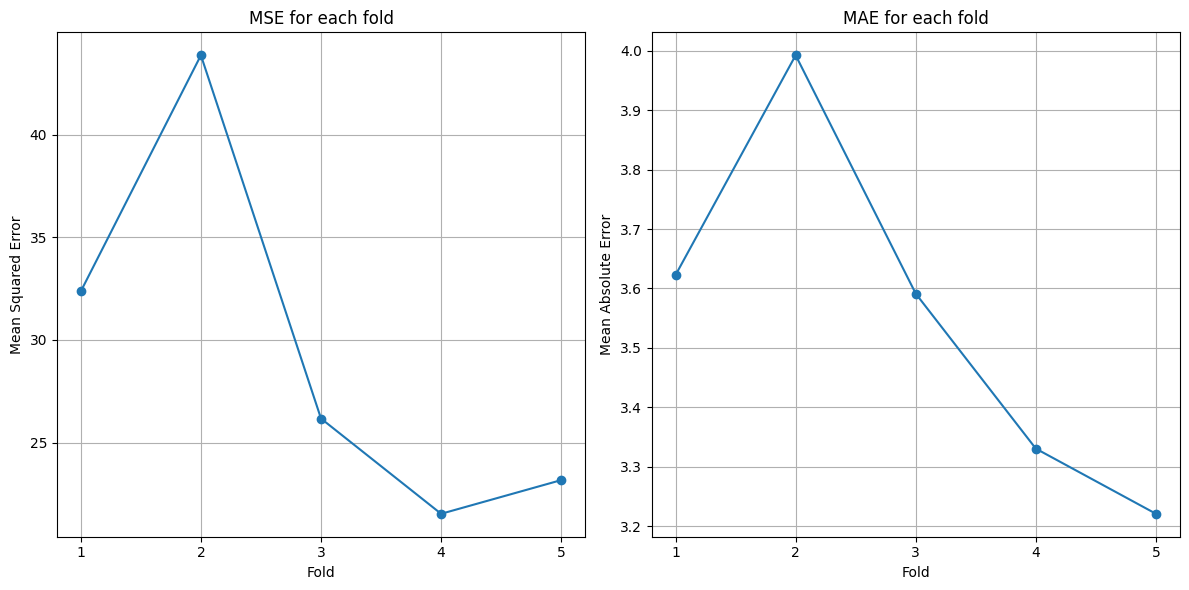

In [25]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(mse_values) + 1), mse_values, marker='o')
plt.title('MSE for each fold')
plt.xlabel('Fold')
plt.ylabel('Mean Squared Error')
plt.xticks(range(1, len(mse_values) + 1))
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, len(mae_values) + 1), mae_values, marker='o')
plt.title('MAE for each fold')
plt.xlabel('Fold')
plt.ylabel('Mean Absolute Error')
plt.xticks(range(1, len(mae_values) + 1))
plt.grid(True)

plt.tight_layout()
plt.show()

## Using Full Dataset

In [26]:
y_scaler = StandardScaler()
preprocessor.fit(X)
X_processed_full = preprocessor.transform(X)

y_scaled_full = y_scaler.fit_transform(y.values.reshape(-1, 1)).flatten()

final_model = keras.Sequential([
    layers.Input(shape=(X_processed_full.shape[1],)),  
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1) 
])

final_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mean_squared_error',
    metrics=['mae', 'mse']
)

final_history = final_model.fit(
    X_processed_full, y_scaled_full,
    epochs=100,
    batch_size=32,
    validation_split=0.1,  
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
    ],
    verbose=1  
)


Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - loss: 0.8519 - mae: 0.6526 - mse: 0.8519 - val_loss: 0.0870 - val_mae: 0.2467 - val_mse: 0.0870 - learning_rate: 0.0010
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3742 - mae: 0.3954 - mse: 0.3742 - val_loss: 0.1208 - val_mae: 0.2577 - val_mse: 0.1208 - learning_rate: 0.0010
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2715 - mae: 0.3574 - mse: 0.2715 - val_loss: 0.0689 - val_mae: 0.2095 - val_mse: 0.0689 - learning_rate: 0.0010
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2044 - mae: 0.3057 - mse: 0.2044 - val_loss: 0.0671 - val_mae: 0.2064 - val_mse: 0.0671 - learning_rate: 0.0010
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2217 - mae: 0.3109 - mse: 0.2217 - val_loss: 0.0785 - val_mae: 0.2221 - val_mse: 0.0785 - learning_rate: 0.0010
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2149 - mae: 0.2974 - mse: 0.2149 - val_loss: 0.0613 - val_mae: 0.2046 - v

In [27]:
sample_indices = X.index[:5]
X_sample = X.loc[sample_indices]
y_sample_actual = y.loc[sample_indices].values  

X_sample_processed = preprocessor.transform(X_sample)

y_sample_pred_scaled = final_model.predict(X_sample_processed).flatten()

y_sample_pred = y_scaler.inverse_transform(y_sample_pred_scaled.reshape(-1, 1)).flatten()

results = pd.DataFrame({
    'Actual': y_sample_actual,
    'Predicted': y_sample_pred
}, index=sample_indices)

print("\nSample Predictions from Final Model:")
print(results)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step

Sample Predictions from Final Model:
   Actual  Predicted
0    65.0  63.286011
1    50.0  47.180813
2     7.0   9.643437
3    20.0  22.972404
4    22.0  19.627800


In [28]:
max_epochs = max([len(h) for h in history_loss])

def pad_history(history, max_len):
    return history + [np.nan]*(max_len - len(history))

history_loss_padded = [pad_history(h, max_epochs) for h in history_loss]
history_val_loss_padded = [pad_history(h, max_epochs) for h in history_val_loss]
history_mae_padded = [pad_history(h, max_epochs) for h in history_mae]
history_val_mae_padded = [pad_history(h, max_epochs) for h in history_val_mae]

df_loss = pd.DataFrame(history_loss_padded).T
df_val_loss = pd.DataFrame(history_val_loss_padded).T
df_mae = pd.DataFrame(history_mae_padded).T
df_val_mae = pd.DataFrame(history_val_mae_padded).T

mean_loss = df_loss.mean(axis=1)
std_loss = df_loss.std(axis=1)
mean_val_loss = df_val_loss.mean(axis=1)
std_val_loss = df_val_loss.std(axis=1)

mean_mae = df_mae.mean(axis=1)
std_mae = df_mae.std(axis=1)
mean_val_mae = df_val_mae.mean(axis=1)
std_val_mae = df_val_mae.std(axis=1)


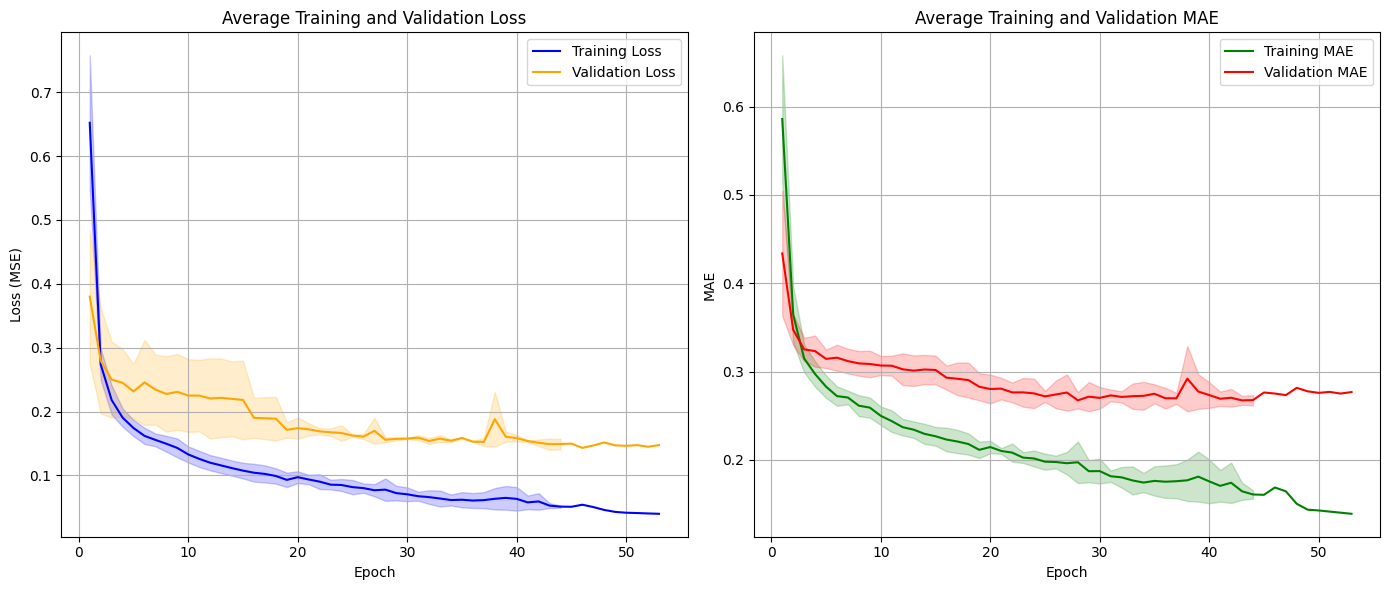

In [29]:
epochs = range(1, max_epochs + 1)

plt.figure(figsize=(14, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, mean_loss, label='Training Loss', color='blue')
plt.fill_between(epochs, mean_loss - std_loss, mean_loss + std_loss, color='blue', alpha=0.2)
plt.plot(epochs, mean_val_loss, label='Validation Loss', color='orange')
plt.fill_between(epochs, mean_val_loss - std_val_loss, mean_val_loss + std_val_loss, color='orange', alpha=0.2)
plt.title('Average Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(epochs, mean_mae, label='Training MAE', color='green')
plt.fill_between(epochs, mean_mae - std_mae, mean_mae + std_mae, color='green', alpha=0.2)
plt.plot(epochs, mean_val_mae, label='Validation MAE', color='red')
plt.fill_between(epochs, mean_val_mae - std_val_mae, mean_val_mae + std_val_mae, color='red', alpha=0.2)
plt.title('Average Training and Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## Hyperparameter tuning

In [30]:
def build_model(hp):
    model = keras.Sequential([
        layers.Input(shape=(X_processed_full.shape[1],)),
        layers.Dense(hp.Int('units_1', min_value=32, max_value=256, step=32), activation='relu'),
        layers.Dense(hp.Int('units_2', min_value=32, max_value=256, step=32), activation='relu'),
        layers.Dense(1)
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[0.001, 0.0001, 0.0001])),
        loss='mean_squared_error',
        metrics=['mae', 'mse']
    )
    return model

tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=50,
    factor=3,
    directory='my_dir',
    project_name='hyperparam_tuning'
)

# Callback for stopping early
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Run the search
tuner.search(
    X_processed_full, y_scaled_full,
    epochs=50,
    validation_split=0.2,
    callbacks=[stop_early]
)

# Get the best hyperparameters and build the model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
Optimal number of units in the first layer: {best_hps.get('units_1')}
Optimal number of units in the second layer: {best_hps.get('units_2')}
Optimal learning rate: {best_hps.get('learning_rate')}
""")

# Train the best model
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(
    X_processed_full, y_scaled_full,
    epochs=50,
    validation_split=0.2,
    callbacks=[stop_early]
)

loss, mae, mse = best_model.evaluate(X_processed_full, y_scaled_full, verbose=0)
print(f"Final model performance: Loss = {loss:.4f}, MAE = {mae:.4f}, MSE = {mse:.4f}")

Trial 90 Complete [00h 00m 07s]
val_loss: 0.09973281621932983

Best val_loss So Far: 0.08256906270980835
Total elapsed time: 00h 05m 20s

Optimal number of units in the first layer: 192
Optimal number of units in the second layer: 224
Optimal learning rate: 0.001

Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.5360 - mae: 0.5507 - mse: 0.5360 - val_loss: 0.3112 - val_mae: 0.3711 - val_mse: 0.3112
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4854 - mae: 0.4620 - mse: 0.4854 - val_loss: 0.1172 - val_mae: 0.2482 - val_mse: 0.1172
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1945 - mae: 0.3012 - mse: 0.1945 - val_loss: 0.1183 - val_mae: 0.2520 - val_mse: 0.1183
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1758 - mae: 0.2903 - mse: 0.1758 - val_loss: 0.1141 - val_mae: 0.2394 - val_mse: 0.1141
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1757 - mae: 0.2810 - mse: 0.1757 - val_loss: 0.1105 - val_mae: 0.2368 - val_mse: 0

## Plot validation loss across trials and epochs

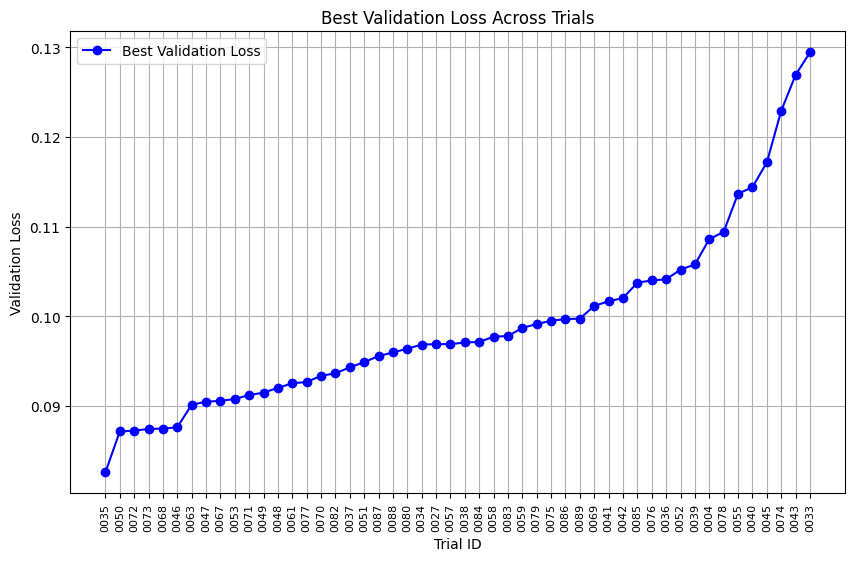

In [31]:
def plot_tuning_results(tuner):
    trials = tuner.oracle.get_best_trials(num_trials=50)  
    trial_ids = [trial.trial_id for trial in trials]
    
    # Extract the best validation loss for each trial
    val_losses = [trial.metrics.get_best_value('val_loss') for trial in trials]

    # Plot the best validation loss per trial
    plt.figure(figsize=(10, 6))
    plt.plot(trial_ids, val_losses, marker='o', linestyle='-', color='blue', label='Best Validation Loss')
    plt.title('Best Validation Loss Across Trials')
    plt.xlabel('Trial ID')
    plt.ylabel('Validation Loss')
    plt.xticks(rotation=90, fontsize=8)
    plt.grid(True)
    plt.legend()
    plt.grid(True)

    plt.show()

plot_tuning_results(tuner)
